# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #08546c; letter-spacing: 2px; text-align: center; border-radius: 8px; border: 3px solid #08546c; background-color: #fffcfa">Playground Series S3E19 - Shapley Values &amp; ML Interpretability</p>

In [58]:
# %load ../general_settings.py
import os
import shutil
import subprocess
import warnings
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
if ON_KAGGLE:
    warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import shap
from colorama import Fore, Style
from IPython.core.display import HTML
from plotly.subplots import make_subplots

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

FONT_COLOR = "#010D36"
BACKGROUND_COLOR = "#F6F5F5"

CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #F6F5F5",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #FF2079; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-style: italic; background-color: #010D36; color: #F2F2F0;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-style: italic; background-color: #010D36; color: #F2F2F0;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)

# Utility functions.
def download_dataset_from_kaggle(user, dataset, directory):
    command = "kaggle datasets download -d "
    filepath = directory / (dataset + ".zip")
    if not filepath.is_file():
        subprocess.run((command + user + "/" + dataset).split())
        filepath.parent.mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(dataset + ".zip", "data")
        shutil.move(dataset + ".zip", "data")


def download_competition_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")
    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


# Html `code` block highlight. Must be included at the end of all imports!
HTML(
    """
<style>
code {
    background: rgba(42, 53, 125, 0.10) !important;
    border-radius: 4px !important;
}
</style>
"""
)


In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from shap import explainers, maskers

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #08546c; letter-spacing: 2px; text-align: center; border-radius: 8px; border: 3px solid #08546c; background-color: #fffcfa">Shapley Values</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #fffcfa;
    padding: 20px;
    border-radius: 8px;
    border: 3px solid #08546c;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Can you explain why your model predicts such and not another value?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    Can you answer this question? If not, <b>SHAP</b> is something for you. I found out about <b>SHAP</b> maybe a week before this notebook was published. I noticed that in several notebooks but without any explanations. Therefore, I was just curious about what is that library and how to utilise it to better understand models.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Shapley values introduction</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    Let's get started with this stuff. Generally, <b>SHAP</b> is a specific approach that helps you understand and explain your model's individual predictions. That method is based on <b>Shapley's values</b> from cooperative game theory. The point is that, we can consider prediction as a game where certain features are players and prediction is a gain. <b>SHAP</b> tells us how to distribute the contribution of each feature into certain prediction fairly. So, what exactly is a Shapley value? Well, it's an <b>average marginal contribution of a feature value across all possible coalitions of features.</b> Understandable? Of course, not. Let me explain this step by step.<br>
    Let's suppose we need to build a machine learning model which has to predict house prices considering different attributes like median house age or average number of rooms. Assume we have only four features to make it as easy as possible. These are the <code>HouseAge</code> (median house age in block group), <code>AveRooms</code> (average number of rooms per household), <code>AveOccup</code> (average number of household members), and <code>Population</code> (block group population). These features are a subset of the California housing dataset from <code>scikit-learn</code>, which we will use later. Okay, so we've just built such a model and test it on a test dataset. It turns out that the average house price is $200,000$. After that, we got a new sample and must predict its price. We get $250,000$, and somebody ask why there is such a difference? <b>More precisely, how much each feature of this certain observation contributes to the prediction compared to the average price?</b><br>
    In the case of linear models, the answer is easy, i.e. the prediction is just the sum of the weight of each feature times the feature value plus intercept. Weights and intercept are found by minimizing the cost function. Nevertheless, in the case of boosted trees or neural networks, the answer is a challenge. For such cases, the problem of model explainability is solved by a method from cooperative game theory - this is the place where <b>SHAP</b> comes into play. It explains the difference between specific prediction and average prediction (made for the whole dataset).
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>How to calculate Shapley value?</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    Calculation of Shapley value for a specific feature is based on coalitions of features. Let's get back to the example with house prices, and suppose we want to calculate the Shapley value for a <code>HouseAge</code> feature for a specific sample. Firstly, consider the coalition of <code>AveRooms</code> and <code>Population</code>. As we want to assess the contribution of <code>HouseAge</code> (for example $30$ for this sample), we take values of these three features for that sample and randomly pick some value for the <code>AveOccup</code> from another sample. We evaluate the model and get a prediction of $220,000$. After that, we remove <code>HouseAge</code> from the coalition by picking the value for that feature from the sample drawn earlier (let's say <code>HouseAge</code> is $40$ there). We re-evaluate the model and get $200,000$. The contribution of <code>HouseAge</code> component is +$20,000$ in this case. These calculations depend on randomly drawn samples, and we should perform many test iterations to get a more reliable result. Moreover, we repeat this calculation for all possible coalitions of features. These coalitions are:
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <li>No coalition of features.</li>
    <li><code>AveRooms</code>.</li>
    <li><code>AveOccup</code>.</li>
    <li><code>Population</code>.</li>
    <li><code>AveRooms</code>, <code>AveOccup</code>.</li>
    <li><code>AveRooms</code>, <code>Population</code>.</li>
    <li><code>AveOccup</code>, <code>Population</code>.</li>
    <li><code>AveRooms</code>, <code>AveOccup</code>, <code>Population</code>.</li>
</ul>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
For all of these coalitions, we compute the predicted price, with and without feature <code>HouseAge</code> value and take marginal contribution as the difference between prices. Let me illustrate this with example of California housing dataset.
</p>
</blockquote>

In [82]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Let's take only four features.
features = ["HouseAge", "AveRooms", "Population", "AveOccup"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X[features], y, test_size=0.1, random_state=42
)

scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = LinearRegression().fit(X_train, y_train)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #fffcfa;
    padding: 20px;
    border-radius: 8px;
    border: 3px solid #08546c;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>What we exactly want to do?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    We want to calculate the Shapley value for a specific sample from the validation dataset by hand and then compare it to the Shapley value obtained from <code>shap</code> library. In this case, we want to explain contribution of <code>HouseAge</code> (which is the first feature - $0$).
</p>
</blockquote>

In [83]:
sample_no = 0  # Number of sample from valid dataset.
feature_no = 0  # Number of feature, which contribution we want to explain.
n_features = len(X_train.columns)

feature_ids = list(range(n_features))
feature_ids.remove(feature_no)

nested_combs = list(list(combinations(feature_ids, r)) for r in range(0, n_features))
features_combs = np.array(list(chain(*nested_combs)), dtype=object)
all_features = np.arange(n_features)

print(CLR + "All possible coalitions of features (without `HouseAge`)")
print(RED + "=>", *features_combs)


All possible coalitions of features (without `HouseAge`)
=> () (1,) (2,) (3,) (1, 2) (1, 3) (2, 3) (1, 2, 3)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #fffcfa;
    padding: 20px;
    border-radius: 8px;
    border: 3px solid #08546c;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Monte Carlo estimation of Shapley value</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    In the case of a large number of features, the calculation for all coalitions is complex. However, there is an approximate method for that, based on <b>Monte-Carlo sampling</b>. This method calculates Shapley value for certain feature $j$ and certain sample $x$:
    \[\hat{\phi}_j(x) = \frac{1}{N}\sum_{n=1}^N \left[\hat{f}(x_{+j}^n) - \hat{f}(x_{-j}^n)\right]\]
where $N$ is the number of sampling steps, $\hat{f}(x_{+j}^n)$ is the prediction for sample $x$ in the step $n$, where the part of feature values from this sample has been replaced by values from randomly picked observation, but value of feature $j$ still comes from $x$. The second part: $\hat{f}(x_{-j}^n)$, is similar to the first one but value of feature $j$ is replaced by value from that randomly chosen observation.<br>
In our case, we have only four features, so all combinations are calculable in a short time, so we perform something between Monte-Carlo sampling and direct calculation.
</p>
</blockquote>

In [84]:
np.random.seed(42)

n_iterations = 2000
marginal_contributions = np.zeros(n_iterations)

for i in range(n_iterations):
    random_no = np.random.randint(len(X_valid))

    x_features = np.array(np.random.choice(features_combs))  # Coalitions
    z_features = np.setdiff1d(all_features, x_features)  # Feature values from random observation.

    x = X_valid.iloc[sample_no, x_features]  # Sample we examine.
    z = X_valid.iloc[random_no, z_features]  # Random sample, which serves as a donor.

    sample = pd.DataFrame({**x.to_dict(), **z.to_dict()}, index=[0])[X_valid.columns]

    sample_p_j = sample.copy()  # Sample with original value of feature `j`.
    sample_m_j = sample.copy()  # Sample with replaced value of feature `j`.

    sample_p_j.iloc[:, feature_no] = X_valid.iloc[sample_no, feature_no]
    sample_m_j.iloc[:, feature_no] = X_valid.iloc[random_no, feature_no]

    marginal_contributions[i] = model.predict(sample_p_j) - model.predict(sample_m_j)

print(CLR + "Shapley value by hand:", RED + f"{marginal_contributions.mean():.5f}")


Shapley value by hand: -0.05325


In [87]:
explainer = explainers.Linear(model, masker=maskers.Independent(X_train, max_samples=len(X_train)))
shap_output = explainer(X_valid.iloc[[sample_no], :])
print(CLR + "SHAP Output:\n")
print(shap_output, "\n")
print(CLR + "Shapley value from SHAP library:", RED + f"{shap_output.values[0, feature_no]:.5f}")


SHAP Output:

.values =
array([[-0.04669537, -0.09805405, -0.00112126, -0.00220943]])

.base_values =
array([2.06861739])

.data =
array([[-0.28671279, -0.49353058, -0.03075389,  0.0726769 ]]) 

Shapley value from SHAP library: -0.04670


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #fffcfa;
    padding: 20px;
    border-radius: 8px;
    border: 3px solid #08546c;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    Using <code>shap</code> library, the Shapley value is hidden in the <code>values</code> attribute of the explainer. We analyse the first feature, so it's the first value of that array. The remaining attributes are: <code>base_values</code>, which means the average prediction for the given dataset, and <code>data</code>, which is exactly the array of our examined sample. As you can see, perhaps the result calculated by hand is not a world champion, but these results are comparable. I checked several different configurations, and these values follow each other.<br>
    Shapley value interpretation may be confusing. <b>The interpretation is that the value of feature $j$ contributed in different coalitions by $\hat{\phi}_j(x)$ to the prediction for this specific observation, in comparison to the average prediction.</b> It's not the difference between predictions when we remove this feature from the dataset.
</p>
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Shapley value properties</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    Shapley value fulfills four axioms. These are:
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <li><b>Efficiency</b> - feature contributions must sum up to the difference of sample prediction and average prediction.</li>
    <li><b>Symmetry</b> - if two fature values equally contribute in all coalitions, then contribution of these should be equal.</li>
    <li><b>Dummy</b> - the Shapley value of the feature value is equal to zero if it doesn't change anything during prediction in different coalitions.</li>
    <li><b>Additivity</b> - in the example of a random forest - if we calculate the Shapley value for each tree individually, average it and then calculate the Shapley value for a random forest, they are the same.</li>
</ul>
</p>
</blockquote>

In [92]:
avg_prediction = model.predict(X_train).mean()
print(CLR + "Average model prediction for valid dataset:", RED + f"{avg_prediction:.5f}")


Average model prediction for valid dataset: 2.06862


In [93]:
sample_prediction = model.predict(X_valid.iloc[[sample_no], :])[0]
print(CLR + "Model prediction for chosen sample:", RED + f"{sample_prediction:.5f}")


Model prediction for chosen sample: 1.92054


In [94]:
print(
    CLR + "Sum of average prediction and all Shapley values:",
    RED + f"{avg_prediction + shap_output.values.sum():.5f}",
)


Sum of average prediction and all Shapley values: 1.92054


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #fffcfa;
    padding: 20px;
    border-radius: 8px;
    border: 3px solid #08546c;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>What is Shapley value?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>The Shapley value is the average marginal contribution of a feature value across all possible coalitions of features.</b><br>
    Understandable? I hope so.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Quick Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    That's all that I wanted to present about Shapley's values. I hope you found out something new. For me, it's a completely new topic so I tried to pass it on best I can. I hope there are no mistakes, but if you are familiar with this topic you can let me know in the comments section. Then, I will try to fix if something is wrong.<br><br>
    <b>References:</b><br>
    <ul style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #08546c;
        margin-left: 15px;
        margin-right: 15px;
    ">
        <li><a href="https://arxiv.org/abs/1705.07874" style="color: #3c5880;"><b>A Unified Approach to Interpreting Model Predictions</b></a></li>
        <li><a href="https://christophm.github.io/interpretable-ml-book/shapley.html" style="color: #3c5880;"><b>Shapley Values</b></a></li>
        <li><a href="https://christophm.github.io/interpretable-ml-book/shap.html" style="color: #3c5880;"><b>SHAP (SHapley Additive exPlanations)</b></a></li>
        <li><a href="https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b" style="color: #3c5880;"><b>A Novel Approach to Feature Importance — Shapley Additive Explanations</b></a></li>
    </ul>
</p>
</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #08546c; letter-spacing: 2px; text-align: center; border-radius: 8px; border: 3px solid #08546c; background-color: #fffcfa">SHAP in Action</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #fffcfa;
    padding: 20px;
    border-radius: 8px;
    border: 3px solid #08546c;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #394d5f;
    border-bottom: 2px solid #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>SHAP Library</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #08546c;
    margin-left: 15px;
    margin-right: 15px;
">
    In this notebook, I use the <code>shap</code> library, about which you can read here: <a href="https://shap.readthedocs.io/en/latest/index.html" style="color: #3c5880;"><b>SHAP documentation</b></a>. In this notebook, I use the <code>shap</code> library, about which you can read here: It constitutes a rich library for explaining any machine learning model (also neural networks). For the purposes of this notebook, we will use a random forest model and appropriate explainer from <code>shap</code> - Tree SHAP.
</p>
</blockquote>

In [220]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

tree_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
feature_names = X_train.columns.to_list()

tree_explainer = shap.explainers.Tree(
    tree_model,
    model_output="raw",  # Explain raw output of the model (output of predict method).
    feature_names=feature_names,
)

tree_explainer.expected_value = tree_explainer.expected_value[0]


In [221]:
shap_output = tree_explainer(X_valid[:100])


Number of validation sample: 4


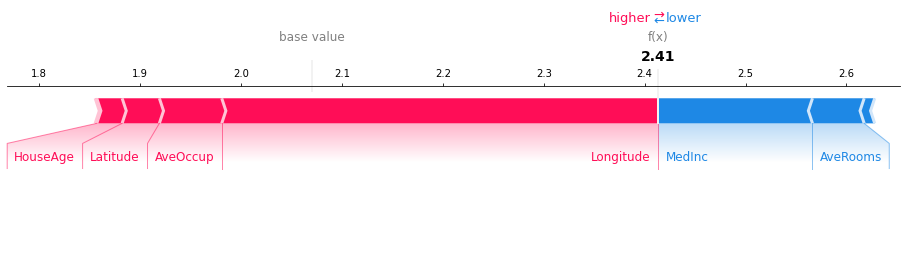

Number of validation sample: 5


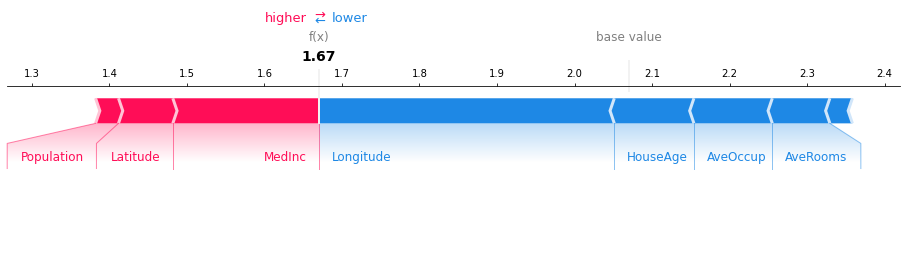

Number of validation sample: 6


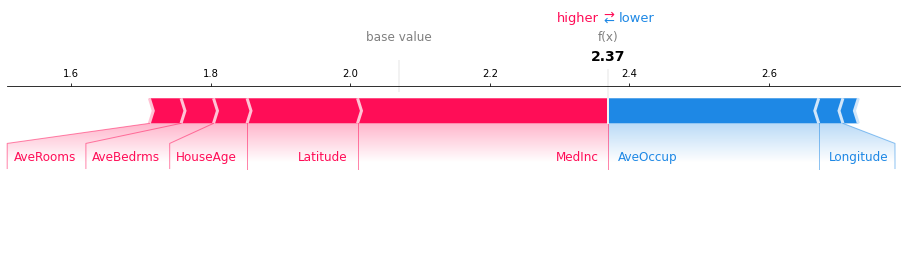

In [222]:
for sample_no in np.arange(4, 7):
    print(CLR + "Number of validation sample:", RED + str(sample_no))
    shap.plots.force(
        tree_explainer.expected_value,
        shap_output.values[sample_no],
        feature_names=feature_names,
        matplotlib=True,
        figsize=(16, 3),
    )


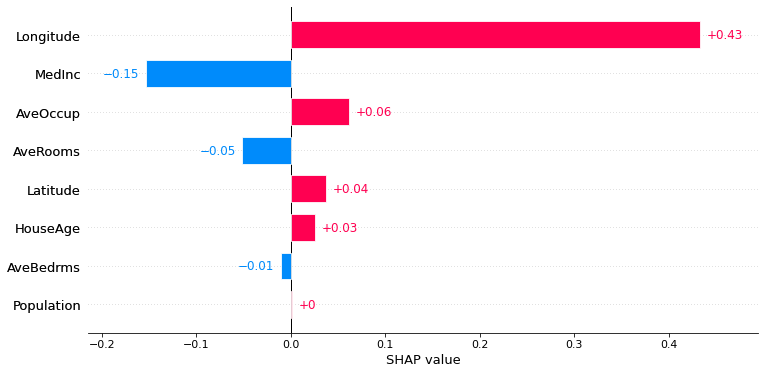

In [223]:
import matplotlib.pyplot as plt

sample_no = 4
shap.plots.bar(shap_output[sample_no], show=False)
plt.gcf().set_size_inches(12, 6)


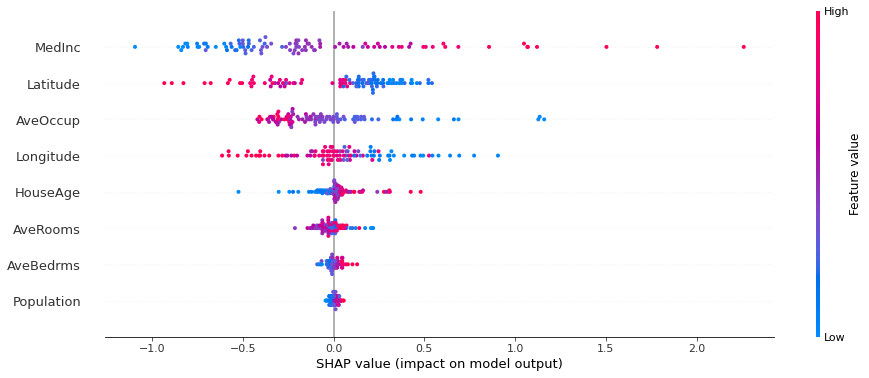

In [224]:
shap.plots.beeswarm(shap_output, plot_size=(15, 6))

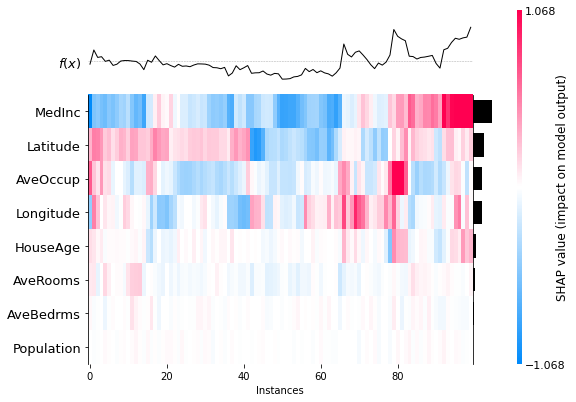

In [225]:
shap.plots.heatmap(shap_output)

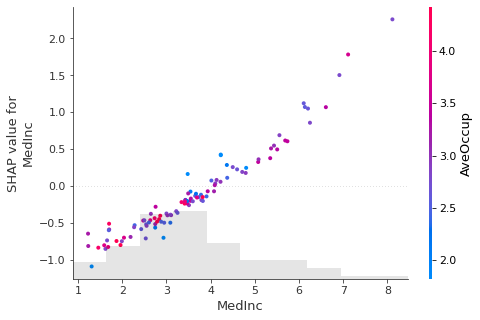

In [232]:
shap.plots.scatter(shap_output[:, "MedInc"], color=shap_output)


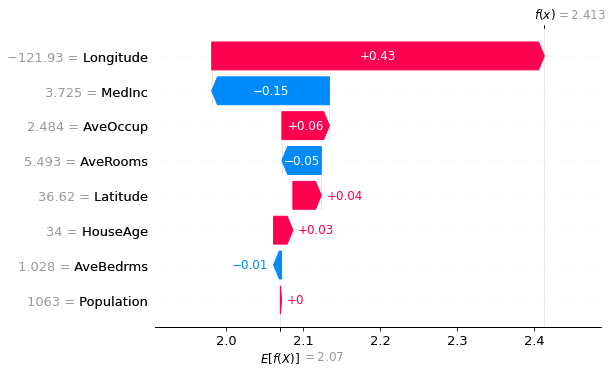

In [234]:
shap.plots.waterfall(shap_output[4])